## Simulated input: 

    - Distograms
    - DAngles
    
For now I will just create smooth normal distributions with mean at the real distance/angle and variance of whatever i want :P.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from get_coords import domains, get_coords
from G_phi_psi import *

In [2]:
coords_real = get_coords('16pkA01')

phi = torch.load('16pkA01_phi.pt')
psi = torch.load('16pkA01_psi.pt')

phi = np.radians(phi[1:])
psi = np.radians(psi[:-1])

phi.requires_grad_(True)
psi.requires_grad_(True)

seq = domains['16pkA01'][2]

In [3]:
initial_geom = G(phi, psi, seq)

extract Calpha and Cbeta atoms

In [3]:
c = []
for i in coords_real:
    if i[3] == 'CA' and i[2] == 'G':
        c.append(i[4:])
    elif i[3] == 'CB':
        c.append(i[4:])
        
c = torch.tensor(c, dtype=torch.float)

dist_map_real = make_distmap(c)

In [4]:
def calc_prob(x, _mean, _sd):
    """Calculates the output of a probability function at value x. The probability function
    is normal with center at _mean and standard deviation _sd"""
    
    return torch.exp(- (1 / 2) * ((x - _mean) / _sd) ** 2) / (_sd * torch.sqrt(torch.tensor(2 * np.pi)))

(0.0, 22.0)

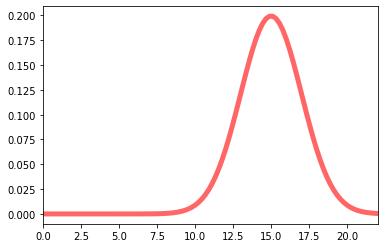

In [5]:
m, s = torch.tensor(15), torch.tensor(2)
x = torch.linspace(0, 22, 100)

y = torch.tensor([calc_prob(i, m, s) for i in x])
plt.plot(x, y,
       'r-', lw=5, alpha=0.6, label='norm pdf')
plt.xlim(0, 22)

In [6]:
plt.imshow(aaa.detach().data.numpy(), cmap='viridis_r')

In [6]:
def loss(pred, real, sd = torch.tensor(4)):
    loss = 0
    
    for i in range(len(pred) - 1):
        for j in range(i + 1, len(pred)):
            prob = calc_prob(pred[i, j], real[i, j], sd)
            loss += torch.log(prob)
    return -loss

In [7]:
def optimize(phi, psi, seq, label, iterations, lr=1e-5, lr_decay = 1, verbose=1):
    
    history = []
    for i in range(iterations):
        if phi.grad is not None:
            phi.grad.zero_()
        if psi.grad is not None:
            psi.grad.zero_()
        
        temp_distmap = G(phi, psi, seq)
        L = loss(temp_distmap, label)
        L.backward()
        phi = (phi - lr * phi.grad).detach().requires_grad_()
        psi = (psi - lr * psi.grad).detach().requires_grad_()
        
        if verbose is not None:
            if i % verbose == 0:
                print(f'Iteration {i}, Loss: {L.item()}')
        history.append([i, L.item()])
        
        lr /= lr_decay
    return phi, psi, np.array(history)

In [9]:
phi_new, psi_new, hist = optimize(phi, psi, seq, dist_map_real, lr=1e-8, iterations=100, verbose = 5)

Iteration 0, Loss: 75869.59375
Iteration 5, Loss: 62524.359375
Iteration 10, Loss: 60332.296875
Iteration 15, Loss: 61267.67578125
Iteration 20, Loss: 63391.7109375
Iteration 25, Loss: 66243.09375
Iteration 30, Loss: 69750.734375
Iteration 35, Loss: 73938.25
Iteration 40, Loss: 78699.8203125
Iteration 45, Loss: 83504.1484375
Iteration 50, Loss: 87079.484375
Iteration 55, Loss: 87797.4140625
Iteration 60, Loss: 85758.5
Iteration 65, Loss: 82961.078125
Iteration 70, Loss: 80479.21875
Iteration 75, Loss: 78516.1875
Iteration 80, Loss: 77064.5
Iteration 85, Loss: 76063.15625
Iteration 90, Loss: 75391.2265625
Iteration 95, Loss: 74937.609375


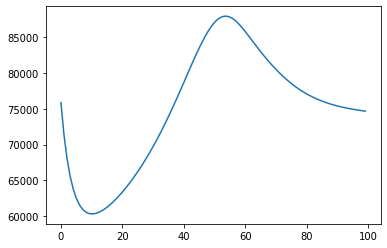

In [10]:
plt.plot(hist[:, 0], hist[:, 1])

In [12]:
phi_new, psi_new, hist = optimize(phi, psi, seq, dist_map_real, lr=1e-5, lr_decay = 2, iterations=20, verbose = 5)

Iteration 0, Loss: 75869.59375
Iteration 5, Loss: 63589.07421875
Iteration 10, Loss: 63901.4296875
Iteration 15, Loss: 63911.921875


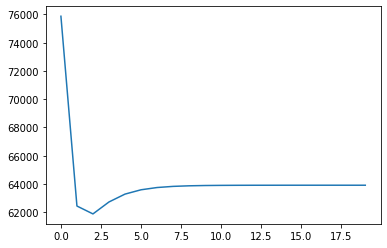

In [13]:
plt.plot(hist[:, 0], hist[:, 1])

In [15]:
d = G(phi, psi, seq)

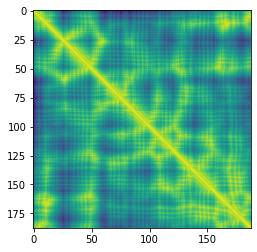

In [20]:
plt.imshow(d.detach().data.numpy() + d.detach().data.numpy().T, cmap='viridis_r')

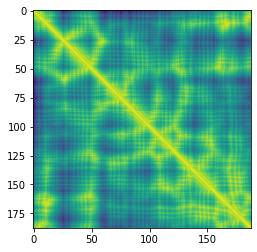

In [23]:
plt.imshow(initial_geom.detach().data.numpy() + initial_geom.detach().data.numpy().T, cmap='viridis_r')

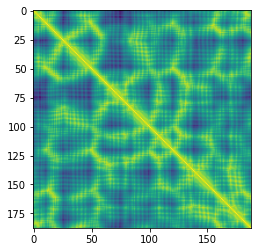

In [25]:
plt.imshow(dist_map_real, cmap='viridis_r')